# Creation des dossiers

In [1]:
from pathlib import Path

ROOT = Path(".").resolve()
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
MODELS_DIR = ROOT / "models"
OUTPUTS_DIR = ROOT / "outputs"

for p in [DATA_RAW, DATA_PROCESSED, MODELS_DIR, OUTPUTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_RAW:", DATA_RAW)


ROOT: C:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1
DATA_RAW: C:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1\data\raw


# Télécharger + extraire Speech Commands v0.02

In [2]:
import urllib.request
import tarfile

URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
ARCHIVE = DATA_RAW / "speech_commands_v0.02.tar.gz"

# 1) download
if not ARCHIVE.exists():
    print("Downloading:", URL)
    urllib.request.urlretrieve(URL, ARCHIVE)
    print("Downloaded:", ARCHIVE)
else:
    print("Archive already exists:", ARCHIVE)

# 2) extract
print("Extracting to:", DATA_RAW)
with tarfile.open(ARCHIVE, "r:gz") as tar:
    tar.extractall(path=DATA_RAW)

print("Done extracting.")

Archive already exists: C:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1\data\raw\speech_commands_v0.02.tar.gz
Extracting to: C:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1\data\raw


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14552\98719791.py:18: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_RAW)


Done extracting.


# Vérifier la structure (important)

In [3]:
# Lister quelques dossiers
dirs = sorted([p.name for p in DATA_RAW.iterdir() if p.is_dir()])
print("Folders in data/raw (first 20):", dirs[:20])
print("Nb folders:", len(dirs))

print("validation_list.txt exists:", (DATA_RAW/"validation_list.txt").exists())
print("testing_list.txt exists:", (DATA_RAW/"testing_list.txt").exists())

Folders in data/raw (first 20): ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no']
Nb folders: 36
validation_list.txt exists: True
testing_list.txt exists: True


# Détecter le dossier dataset (root)

In [4]:
from pathlib import Path

def find_dataset_dir(base: Path) -> Path:
    # cas 1: fichiers list directement dans data/raw
    if (base/"validation_list.txt").exists() and (base/"testing_list.txt").exists():
        return base
    # cas 2: un sous-dossier contient les fichiers list
    for sub in base.iterdir():
        if sub.is_dir() and (sub/"validation_list.txt").exists() and (sub/"testing_list.txt").exists():
            return sub
    raise FileNotFoundError("Impossible de trouver validation_list.txt/testing_list.txt")

DATASET_DIR = find_dataset_dir(DATA_RAW)
print("DATASET_DIR =", DATASET_DIR)


DATASET_DIR = C:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1\data\raw


# Définir les 10 commandes (projet simple & standard)

In [5]:
TARGET_WORDS = ["yes","no","up","down","left","right","on","off","stop","go"]
SILENCE_LABEL = "silence"
UNKNOWN_LABEL = "unknown"


# Charger les listes officielles (val/test) + construire train

In [6]:
def read_list(fp):
    return set(x.strip() for x in fp.read_text().splitlines() if x.strip())

val_list = read_list(DATASET_DIR / "validation_list.txt")
test_list = read_list(DATASET_DIR / "testing_list.txt")

len(val_list), len(test_list), list(sorted(list(val_list)))[0][:40]


(9981, 11005, 'backward/067f61e2_nohash_0.wav')

# Récupérer tous les fichiers WAV + split train/val/test

In [7]:
import random
from collections import defaultdict

random.seed(42)

def relpath_str(p: Path) -> str:
    # format attendu par les fichiers list: "word/xxx.wav"
    return str(p.relative_to(DATASET_DIR)).replace("\\", "/")

def split_of(rel: str) -> str:
    if rel in val_list: return "val"
    if rel in test_list: return "test"
    return "train"

# dossiers "mots" présents
word_dirs = sorted([d.name for d in DATASET_DIR.iterdir() if d.is_dir() and not d.name.startswith(".")])
special = set(["_background_noise_"])
# parfois il peut y avoir SpeechCommands comme dossier parasite
special.add("SpeechCommands")

unknown_words = [w for w in word_dirs if (w not in TARGET_WORDS and w not in special)]
print("Nb dossiers:", len(word_dirs))
print("Exemples unknown:", unknown_words[:15])

files_by_split_label = defaultdict(list)

# 1) fichiers des TARGET_WORDS
for w in TARGET_WORDS:
    for wav in (DATASET_DIR / w).glob("*.wav"):
        rel = relpath_str(wav)
        sp = split_of(rel)
        files_by_split_label[(sp, w)].append(wav)

# 2) fichiers "unknown" = tous les autres mots (on va échantillonner ensuite)
unknown_pool = defaultdict(list)
for w in unknown_words:
    for wav in (DATASET_DIR / w).glob("*.wav"):
        rel = relpath_str(wav)
        sp = split_of(rel)
        unknown_pool[sp].append(wav)

print("Unknown pool sizes:", {k: len(v) for k,v in unknown_pool.items()})

Nb dossiers: 36
Exemples unknown: ['backward', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'follow', 'forward', 'four', 'happy', 'house', 'learn', 'marvin', 'nine']
Unknown pool sizes: {'train': 54074, 'test': 6931, 'val': 6278}


# Équilibrer les classes (simple & propre)

In [8]:
def sample_list(lst, n):
    if len(lst) <= n:
        return lst[:]  # si pas assez, on prend tout
    return random.sample(lst, n)

balanced = {"train": [], "val": [], "test": []}
stats = {}

for sp in ["train","val","test"]:
    # N = min sur les 10 commandes, pour ce split
    counts = [len(files_by_split_label[(sp, w)]) for w in TARGET_WORDS]
    N = min(counts)
    stats[sp] = {"N_per_target": N, "counts_targets": dict(zip(TARGET_WORDS, counts))}

    # 10 commandes
    for w in TARGET_WORDS:
        balanced[sp] += [(p, w) for p in sample_list(files_by_split_label[(sp, w)], N)]

    # unknown : N (même taille qu’une classe)
    balanced[sp] += [(p, UNKNOWN_LABEL) for p in sample_list(unknown_pool[sp], N)]

print("Stats (N):", {sp: stats[sp]["N_per_target"] for sp in stats})
for sp in balanced:
    print(sp, "total items (sans silence):", len(balanced[sp]))

Stats (N): {'train': 2948, 'val': 350, 'test': 396}
train total items (sans silence): 32428
val total items (sans silence): 3850
test total items (sans silence): 4356


# distribution

In [9]:
from collections import Counter

for sp in ["train","val","test"]:
    c = Counter(label for _,label in balanced[sp])
    print(sp, c)

train Counter({'yes': 2948, 'no': 2948, 'up': 2948, 'down': 2948, 'left': 2948, 'right': 2948, 'on': 2948, 'off': 2948, 'stop': 2948, 'go': 2948, 'unknown': 2948})
val Counter({'yes': 350, 'no': 350, 'up': 350, 'down': 350, 'left': 350, 'right': 350, 'on': 350, 'off': 350, 'stop': 350, 'go': 350, 'unknown': 350})
test Counter({'yes': 396, 'no': 396, 'up': 396, 'down': 396, 'left': 396, 'right': 396, 'on': 396, 'off': 396, 'stop': 396, 'go': 396, 'unknown': 396})


-----

# 1) Paramètres + dossiers

In [10]:
SR = 16000          # Speech Commands est en 16 kHz
DURATION = 1.0
SAMPLES = int(SR * DURATION)

N_MFCC = 40
WIN_LENGTH = int(0.025 * SR)   # 25ms -> 400 samples
HOP_LENGTH = int(0.010 * SR)   # 10ms -> 160 samples
N_FFT = 512

# nb de frames attendu (avec center=False)
T_FRAMES = 1 + (SAMPLES - N_FFT) // HOP_LENGTH
T_FRAMES

97

# 2) Ajouter la classe silence à partir de _background_noise_
*Ici on génère N exemples “silence” par split (même N que par classe), en prenant des segments 1 seconde dans les bruits de fond.*

In [11]:
import soundfile as sf

SILENCE_LABEL = "silence"
UNKNOWN_LABEL = "unknown"
TARGET_WORDS = ["yes","no","up","down","left","right","on","off","stop","go"]

# balanced est ton dict existant: balanced["train"] = [(Path,label), ...]
# stats[sp]["N_per_target"] existe aussi (N=2948 train, 350 val, 396 test)

bg_dir = DATASET_DIR / "_background_noise_"
bg_files = sorted(list(bg_dir.glob("*.wav")))
assert len(bg_files) > 0, "Pas de fichiers dans _background_noise_"
print("Background files:", [p.name for p in bg_files])

def bg_num_frames(p):
    return sf.info(str(p)).frames

def make_silence_samples(n):
    out = []
    for _ in range(n):
        bg = random.choice(bg_files)
        frames = bg_num_frames(bg)
        if frames <= SAMPLES:
            start = 0
        else:
            start = random.randint(0, frames - SAMPLES - 1)
        out.append((bg, SILENCE_LABEL, start))
    return out

# On convertit balanced -> samples (path, label, start=None)
samples = {}
for sp in ["train","val","test"]:
    base = [(p, label, None) for (p, label) in balanced[sp]]
    n = stats[sp]["N_per_target"]
    base += make_silence_samples(n)
    random.shuffle(base)
    samples[sp] = base

# Vérif distribution rapide
from collections import Counter
for sp in ["train","val","test"]:
    c = Counter(label for _,label,_ in samples[sp])
    print(sp, c)

Background files: ['doing_the_dishes.wav', 'dude_miaowing.wav', 'exercise_bike.wav', 'pink_noise.wav', 'running_tap.wav', 'white_noise.wav']
train Counter({'down': 2948, 'no': 2948, 'silence': 2948, 'stop': 2948, 'left': 2948, 'up': 2948, 'unknown': 2948, 'off': 2948, 'right': 2948, 'on': 2948, 'go': 2948, 'yes': 2948})
val Counter({'off': 350, 'silence': 350, 'up': 350, 'stop': 350, 'no': 350, 'right': 350, 'left': 350, 'down': 350, 'on': 350, 'go': 350, 'unknown': 350, 'yes': 350})
test Counter({'left': 396, 'silence': 396, 'off': 396, 'up': 396, 'down': 396, 'right': 396, 'no': 396, 'unknown': 396, 'on': 396, 'yes': 396, 'stop': 396, 'go': 396})


# 3) Extraction MFCC (features séquentielles pour GRU/LSTM)

In [12]:
import numpy as np
import librosa

def load_1s_audio(path, start=None):
    """
    - si start=None : charge un wav normal (commande)
    - si start=int : charge segment 1s dans un bruit de fond (silence)
    """
    if start is None:
        y, _ = librosa.load(path, sr=SR)
        # pad/trim à 1 seconde
        if len(y) < SAMPLES:
            y = np.pad(y, (0, SAMPLES - len(y)))
        else:
            y = y[:SAMPLES]
        return y.astype(np.float32)
    else:
        # lire seulement la portion utile du background noise
        with sf.SoundFile(str(path)) as f:
            f.seek(start)
            y = f.read(SAMPLES, dtype="float32")
        if len(y) < SAMPLES:
            y = np.pad(y, (0, SAMPLES - len(y)))
        return y.astype(np.float32)

def wav_to_mfcc_seq(y):
    mfcc = librosa.feature.mfcc(
        y=y, sr=SR, n_mfcc=N_MFCC,
        n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
        center=False
    ).T  # (time, n_mfcc)

    # sécuriser longueur (au cas où)
    if mfcc.shape[0] < T_FRAMES:
        mfcc = np.pad(mfcc, ((0, T_FRAMES - mfcc.shape[0]), (0, 0)))
    else:
        mfcc = mfcc[:T_FRAMES]
    return mfcc.astype(np.float32)


# 4) Construire X/y + normalisation (train → val/test)

In [13]:
from tqdm import tqdm

LABELS = TARGET_WORDS + [UNKNOWN_LABEL, SILENCE_LABEL]
label2id = {lab:i for i,lab in enumerate(LABELS)}
id2label = {i:lab for lab,i in label2id.items()}

def build_xy(split_name):
    items = samples[split_name]
    X = np.zeros((len(items), T_FRAMES, N_MFCC), dtype=np.float32)
    y = np.zeros((len(items),), dtype=np.int64)

    for i, (path, label, start) in enumerate(tqdm(items, desc=f"MFCC {split_name}")):
        audio = load_1s_audio(path, start=start)
        X[i] = wav_to_mfcc_seq(audio)
        y[i] = label2id[label]
    return X, y

X_train, y_train = build_xy("train")
X_val, y_val     = build_xy("val")
X_test, y_test   = build_xy("test")

# Normalisation: mean/std calculés sur TRAIN seulement
mu = X_train.reshape(-1, N_MFCC).mean(axis=0)
sigma = X_train.reshape(-1, N_MFCC).std(axis=0) + 1e-6

X_train = (X_train - mu) / sigma
X_val   = (X_val   - mu) / sigma
X_test  = (X_test  - mu) / sigma

# Sauvegarde
np.savez_compressed(
    DATA_PROCESSED / f"speech_mfcc{N_MFCC}_T{T_FRAMES}.npz",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    mu=mu, sigma=sigma,
    labels=np.array(LABELS, dtype=object)
)

X_train.shape, y_train.shape


MFCC train:   0%|          | 0/35376 [00:00<?, ?it/s]c:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
MFCC test: 100%|██████████| 4752/4752 [02:28<00:00, 32.06it/s]


((35376, 97, 40), (35376,))

---
#                             MODELE GRU

## 1) Imports sparse

In [14]:
import sys; print(sys.executable); print(sys.version)


c:\Users\Administrator\OneDrive\Bureau\@ProgrammeAI_cours_session_04\Apprentissage profond appliqué avancé\projetUA1\.venv\Scripts\python.exe
3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(LABELS)
print("num_classes =", num_classes, LABELS)

num_classes = 12 ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']


## 2) Construire le modèle GRU (simple + efficace)

In [16]:
tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  # (T, 40)
    layers.GRU(128, return_sequences=False),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        65,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,340 (325.55 KB)

 Trainable params: 83,340 (325.55 KB)

 Non-trainable params: 0 (0.00 B)

## 3) Entraîner (EarlyStopping + checkpoint)

In [17]:
from tensorflow import keras

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / "gru_speech_commands.keras"),
        monitor="val_accuracy",
        save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,          # plafond seulement
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 129s 431ms/step - accuracy: 0.2442 - loss: 2.0772 - val_accuracy: 0.4588 - val_loss: 1.4647 - learning_rate: 0.0010
Epoch 2/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 113s 404ms/step - accuracy: 0.5585 - loss: 1.2153 - val_accuracy: 0.7117 - val_loss: 0.8455 - learning_rate: 0.0010
Epoch 3/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 104s 376ms/step - accuracy: 0.7596 - loss: 0.7035 - val_accuracy: 0.8314 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 4/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 106s 382ms/step - accuracy: 0.8451 - loss: 0.4735 - val_accuracy: 0.8676 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 5/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 98s 352ms/step - accuracy: 0.8846 - loss: 0.3669 - val_accuracy: 0.8769 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 6/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 91s 328ms/step - accuracy: 0.9047 - loss: 0.2991 - val_accuracy: 0.8890 - val_loss: 0.3659 - learning_rate: 0.0010
Epoch 7/30
277/277 ━━━━━━━━━━━━━━━━━━━━ 90s 323ms/step - accuracy:

## 4) Courbes (loss/accuracy)

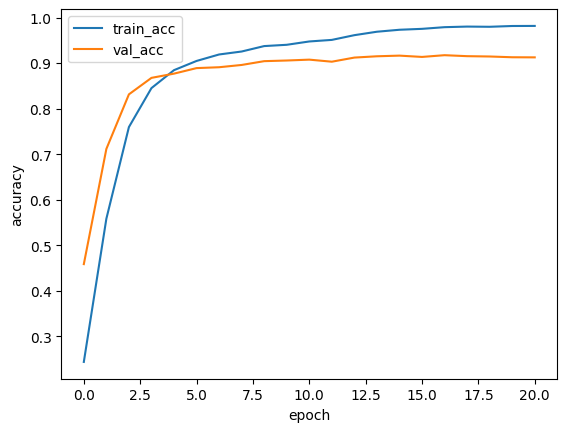

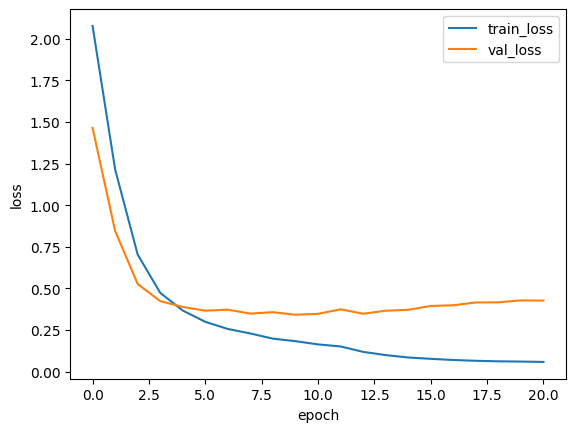

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


## 5) Évaluer sur le test set

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("TEST accuracy:", test_acc, "| loss:", test_loss)


TEST accuracy: 0.9130892157554626 | loss: 0.4061374068260193


## 6) Confusion matrix + rapport

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

print(classification_report(
    y_test, y_pred,
    target_names=LABELS,
    digits=4
))


              precision    recall  f1-score   support

         yes     0.9435    0.9697    0.9564       396
          no     0.8908    0.9066    0.8986       396
          up     0.9306    0.9141    0.9223       396
        down     0.9208    0.8510    0.8845       396
        left     0.9221    0.9268    0.9244       396
       right     0.9608    0.9293    0.9448       396
          on     0.9213    0.9167    0.9190       396
         off     0.9213    0.9167    0.9190       396
        stop     0.9373    0.9444    0.9409       396
          go     0.8582    0.8712    0.8647       396
     unknown     0.7625    0.8106    0.7858       396
     silence     1.0000    1.0000    1.0000       396

    accuracy                         0.9131      4752
   macro avg     0.9141    0.9131    0.9134      4752
weighted avg     0.9141    0.9131    0.9134      4752



## Heatmap simple (matplotlib)

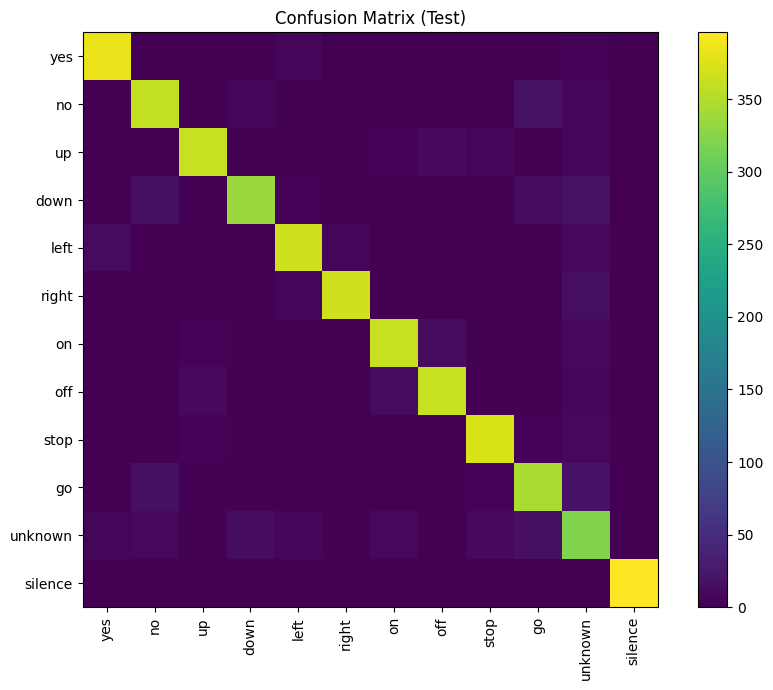

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9, 7))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
plt.xticks(range(num_classes), LABELS, rotation=90)
plt.yticks(range(num_classes), LABELS)
plt.tight_layout()
plt.show()


## 7) Tester sur quelques exemples (prédictions lisibles)

In [22]:
import random

def show_predictions(n=10):
    idxs = random.sample(range(len(X_test)), n)
    for i in idxs:
        true_lab = id2label[int(y_test[i])]
        pred_lab = id2label[int(y_pred[i])]
        conf = float(np.max(y_proba[i]))
        print(f"{i:5d} | true={true_lab:8s} | pred={pred_lab:8s} | conf={conf:.3f}")

show_predictions(15)


 3193 | true=right    | pred=right    | conf=1.000
 3538 | true=right    | pred=right    | conf=1.000
 4235 | true=silence  | pred=silence  | conf=1.000
   85 | true=silence  | pred=silence  | conf=1.000
 1228 | true=up       | pred=up       | conf=1.000
 3214 | true=yes      | pred=yes      | conf=1.000
 4544 | true=up       | pred=up       | conf=1.000
 3895 | true=right    | pred=right    | conf=1.000
 2391 | true=yes      | pred=yes      | conf=1.000
 4582 | true=stop     | pred=stop     | conf=1.000
 2830 | true=on       | pred=on       | conf=0.954
  908 | true=up       | pred=up       | conf=1.000
  841 | true=on       | pred=off      | conf=1.000
 3648 | true=stop     | pred=stop     | conf=1.000
 3474 | true=down     | pred=down     | conf=1.000


Le modèle GRU entraîné sur des features MFCC (40 coefficients) atteint une accuracy de 0.914 sur l’ensemble de test. Les classes de commandes principales sont bien reconnues, avec des performances élevées sur la majorité des mots et une détection parfaite de la classe “silence”. La principale difficulté concerne la classe “unknown”, qui regroupe un ensemble hétérogène de mots et génère la majorité des confusions. Globalement, l’approche MFCC + GRU constitue une solution efficace et simple pour la reconnaissance de commandes vocales.

# Une petite PRATIQUE

### 1) Charger le modèle sauvegardé

In [23]:
import tensorflow as tf
from tensorflow import keras

model_path = MODELS_DIR / "gru_speech_commands.keras"
model = keras.models.load_model(str(model_path))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        65,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,022 (976.65 KB)

 Trainable params: 83,340 (325.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,682 (651.11 KB)

### 2) Recréer exactement le prétraitement (MFCC + normalisation)

In [24]:
import numpy as np
import librosa

SR = 16000
DURATION = 1.0
SAMPLES = int(SR * DURATION)

N_MFCC = 40
WIN_LENGTH = int(0.025 * SR)
HOP_LENGTH = int(0.010 * SR)
N_FFT = 512
T_FRAMES = 97 


from pathlib import Path
DATA_PROCESSED 
npz_path = list(DATA_PROCESSED.glob("speech_mfcc40_T97.npz"))[0]
data = np.load(npz_path, allow_pickle=True)

mu = data["mu"]
sigma = data["sigma"]
LABELS = list(data["labels"])
id2label = {i:lab for i,lab in enumerate(LABELS)}

def preprocess_wav_to_input(wav_path: str):
    # 1) load wav
    y, _ = librosa.load(wav_path, sr=SR)
    # 2) pad/trim à 1 seconde
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))
    else:
        y = y[:SAMPLES]

    # 3) MFCC (T, 40)
    mfcc = librosa.feature.mfcc(
        y=y, sr=SR, n_mfcc=N_MFCC,
        n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
        center=False
    ).T

    # 4) sécuriser longueur T
    if mfcc.shape[0] < T_FRAMES:
        mfcc = np.pad(mfcc, ((0, T_FRAMES - mfcc.shape[0]), (0, 0)))
    else:
        mfcc = mfcc[:T_FRAMES]

    # 5) normalisation
    mfcc = (mfcc - mu) / sigma

    # 6) ajouter batch dimension -> (1, T, 40)
    return mfcc.astype(np.float32)[None, ...]


### 3) Fonction de prédiction

In [25]:
def predict_command(wav_path: str, topk: int = 3):
    x = preprocess_wav_to_input(wav_path)
    proba = model.predict(x, verbose=0)[0]
    idxs = np.argsort(proba)[::-1][:topk]
    results = [(id2label[int(i)], float(proba[i])) for i in idxs]
    return results

# Exemple: un wav du dataset
example_wav = next((DATASET_DIR / "yes").glob("*.wav"))
predict_command(example_wav)


[('yes', 0.999997615814209),
 ('left', 1.0137747494809446e-06),
 ('unknown', 7.241695811899262e-07)]

In [26]:
from pathlib import Path

print("Model exists:", (MODELS_DIR / "gru_speech_commands.keras").exists())
print("NPZ exists:", any(DATA_PROCESSED.glob("speech_mfcc*_T*.npz")))
print("Raw data folders count:", len([p for p in DATA_RAW.iterdir() if p.is_dir()]))

Model exists: True
NPZ exists: True
Raw data folders count: 36
